In [ ]:
from distutils.dir_util import copy_tree
from google.colab import drive
import shutil 
import numpy as np
from scipy.io import loadmat
import cvxpy as cp
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from scipy.io import loadmat
import numpy as np
import json
import os 
from tqdm import tqdm
import cv2
import numpy as np
import glob
import sys
from pathlib import Path
import matplotlib.pyplot as plt
from skimage import data
from skimage.util.dtype import dtype_range
from skimage.util import img_as_ubyte
from skimage import exposure
from skimage.morphology import disk
from skimage.morphology import ball
from skimage.filters import rank
from skimage.data import text
from skimage.filters import threshold_mean, threshold_triangle

from skimage.filters import try_all_threshold
from skimage.restoration import *
# loading the dataset the masks produced with grabcut and 3D keypoints form google drive 
drive.mount('/content/drive')

source = 'drive/MyDrive/Datasets/Datasets.zip'
destination  = 'Datasets.zip'

shutil.copy2(source, destination)


import zipfile
with zipfile.ZipFile('Datasets.zip', 'r') as zip_ref:
    zip_ref.extractall('')

source = 'drive/MyDrive/mask.zip'
destination  = 'mask.zip'

shutil.copy2(source, destination)

source = 'drive/MyDrive/mask2.zip'
destination  = 'mask2.zip'

shutil.copy2(source, destination)
import zipfile
with zipfile.ZipFile('mask2.zip', 'r') as zip_ref:
    zip_ref.extractall('masks/')



import zipfile
with zipfile.ZipFile('mask.zip', 'r') as zip_ref:
    zip_ref.extractall('masks/')

source = 'drive/MyDrive/Datasets/keypoint3D.mat'
destination  = 'keypoint3D.mat'

shutil.copy2(source, destination)

Mounted at /content/drive


'keypoint3D.mat'

In [ ]:
keypoints = loadmat('keypoint3D.mat')['keypoints']

camera = [[2988.5795163815555,0,960], [0 ,2988.3401159176124,600] ,[0,0, 1]]
dist =[
    -0.22383016606510672,
     0.51409797089106379,
    -0.00066499611998340662,
    -0.00021404771667484594,
    -0.13124227429077406
  ]



## FUNCTIONS

def quat2dcm(q):
    """ Computing direction cosine matrix from quaternion, adapted from PyNav. """
    # normalizing quaternion
    q = q / np.linalg.norm(q)

    q0 = q[0]
    q1 = q[1]
    q2 = q[2]
    q3 = q[3]

    dcm = np.zeros((3, 3), dtype=np.float32)

    dcm[0, 0] = 2 * q0 ** 2 - 1 + 2 * q1 ** 2
    dcm[1, 1] = 2 * q0 ** 2 - 1 + 2 * q2 ** 2
    dcm[2, 2] = 2 * q0 ** 2 - 1 + 2 * q3 ** 2

    dcm[0, 1] = 2 * q1 * q2 + 2 * q0 * q3
    dcm[0, 2] = 2 * q1 * q3 - 2 * q0 * q2

    dcm[1, 0] = 2 * q1 * q2 - 2 * q0 * q3
    dcm[1, 2] = 2 * q2 * q3 + 2 * q0 * q1

    dcm[2, 0] = 2 * q1 * q3 + 2 * q0 * q2
    dcm[2, 1] = 2 * q2 * q3 - 2 * q0 * q1

    return dcm


def project_keypoints(q, r, K, dist, keypoints):
    """ Projecting 3D keypoints to 2D
        q: quaternion (np.array)
        r: position   (np.array)
        K: camera intrinsic (3,3) (np.array)
        dist: distortion coefficients (5,) (np.array)
        keypoints: N x 3 or 3 x N (np.array)
    """
    # Make sure keypoints are 3 x N
    if keypoints.shape[0] != 3:
        keypoints = np.transpose(keypoints)

    # Keypoints into 4 x N homogenous coordinates
    keypoints = np.vstack((keypoints, np.ones((1, keypoints.shape[1]))))

    # transformation to image frame
    pose_mat = np.hstack((np.transpose(quat2dcm(q)), np.expand_dims(r, 1)))
    xyz      = np.dot(pose_mat, keypoints) # [3 x N]
    x0, y0   = xyz[0,:] / xyz[2,:], xyz[1,:] / xyz[2,:] # [1 x N] each
    # print(x0)
    # print(y0)

    # apply distortion
    r2 = x0*x0 + y0*y0
    cdist = 1 + dist[0]*r2 + dist[1]*r2*r2 + dist[4]*r2*r2*r2
    x  = x0*cdist + dist[2]*2*x0*y0 + dist[3]*(r2 + 2*x0*x0)
    y  = y0*cdist + dist[2]*(r2 + 2*y0*y0) + dist[3]*2*x0*y0

    # apply camera matrix
    points2D = np.vstack((K[0][0]*x + K[0][2], K[1][1]*y + K[1][2]))

    return points2D

def area_removing(image,xmin,xmax,ymin,ymax, margin):
  shape = np.shape(image)
  for i in range(shape[0]):
    for j in range(shape[1]):
      if j < (xmin - margin) or j > (xmax + margin) or i< (ymin - margin) or i>(ymax + margin):
        image[i][j] = 0
  return image

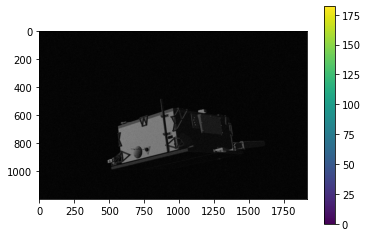

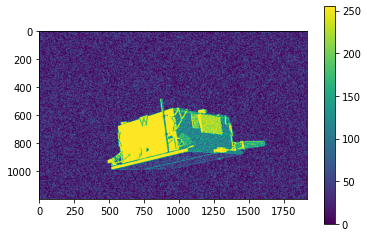

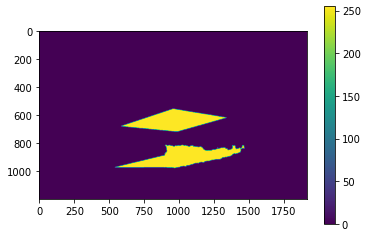

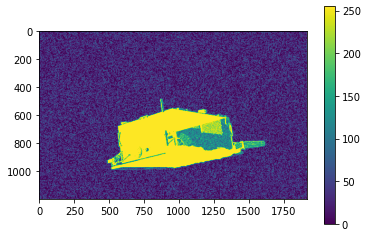

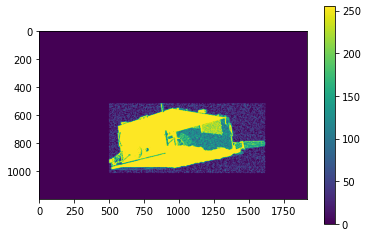

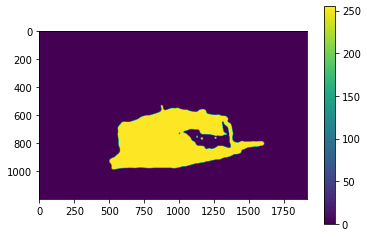

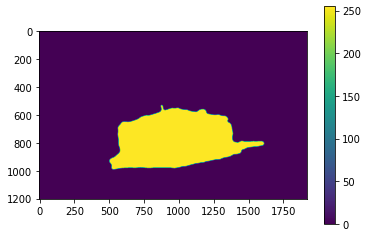

(<matplotlib.image.AxesImage at 0x7fc1881ff0d0>,
 None)

In [ ]:
def check_grayscale(frame):
    if len(frame.shape)==2:
        return frame
    if len(frame.shape)==3:
        return cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

WRITEIMAGES = 0
# opend the train.json which contain the labels for each image and their name
f = open('train.json')
data_list = json.load(f)

# for index in tqdm(range(7500)):
data = data_list[4]
path = 'Datasets/synthetic/images/'+data['filename']
points2D = project_keypoints(data['q_vbs2tango'], data['r_Vo2To_vbs_true'], camera, dist, keypoints)
# keypts2d = np.transpose(points2D)
keypts2d = points2D
xmin = np.min(keypts2d[0])
ymin = np.min(keypts2d[1])
xmax = np.max(keypts2d[0])
ymax = np.max(keypts2d[1])
image = cv2.imread(path) 

plt.imshow(image),plt.colorbar(),plt.show()

#converting image to grayscale
image_grayscale = check_grayscale(image).astype(np.uint8)
# finding the mean threshold
thresh = threshold_mean(image_grayscale)
# applying the mean threshold
binary = np.array( image_grayscale > thresh )
plt.imshow(binary*255),plt.colorbar(),plt.show()
#reading the grab_cut maskes
mask = np.array(check_grayscale(cv2.imread('masks/'+data['filename']).astype(np.uint8)))
plt.imshow(mask*255),plt.colorbar(),plt.show()
# logical or of mean threshold and grab cut mask
final_mask = binary | mask
plt.imshow(final_mask*255),plt.colorbar(),plt.show()
final_mask = area_removing(final_mask,xmin,xmax,ymin,ymax,40)
# cv2_imshow(final_mask*255)
plt.imshow(final_mask*255),plt.colorbar(),plt.show()
# # three layer of noise cancelation
# final_mask = cv2.fastNlMeansDenoising(final_mask, None, 5, 9) 
final_mask = cv2.fastNlMeansDenoising(final_mask, None, 20, 7, 21) 
final_mask = cv2.fastNlMeansDenoising(final_mask, None, 20, 7, 21)
# # cv2_imshow(final_mask*255)
# plt.imshow(final_mask*255),plt.colorbar(),plt.show()
# # applying floodfill method to fill the enclosed areas in the images
plt.imshow(final_mask*255),plt.colorbar(),plt.show()

th, im_th = cv2.threshold(final_mask*255, 220, 255, cv2.THRESH_BINARY_INV);
im_floodfill = im_th.copy()
h, w = im_th.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)
cv2.floodFill(im_floodfill, mask, (0,0), 255);
# # since the flood fill image the background is one and spacecraft is zero we reverse the binary mask
mask = 1 - mask
plt.imshow(mask*255),plt.colorbar(),plt.show()
# cv2.imwrite('sample_masks/'+data['filename'],(mask*255))




In [ ]:
import shutil
shutil.make_archive('sample_mask', 'zip', 'sample_masks')

'/content/sample_mask.zip'

In [ ]:

source = 'sample_mask.zip'

destination  = 'drive/MyDrive/sample_mask_new.zip'

shutil.copy2(source, destination)

'drive/MyDrive/sample_mask_new.zip'